In [3]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import math
from datetime import date
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


#import the dataset
data = pd.read_csv("kickstarter_dataset/ks-projects-201801.csv")

In [4]:
len(data), len(list(data))

(378661, 15)

In [5]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [6]:
#check for nulls
data.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [7]:
#usd_pledged has many empty rows and since its not important information
#I decided to get rid of it
data = data.drop("usd pledged", 1)
#remove the backers and pledged columns because they are not relevant for this research
data = data.drop("backers", 1)
data = data.drop("pledged", 1)

In [8]:
#check the projects without a name
#since the name isnt important for this purpose these can be left as is 
#because they have the other information we need
data[data["name"].isnull()]

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_pledged_real,usd_goal_real
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.0,2012-01-01 12:35:31,failed,US,100.00,200000.00
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.0,2012-12-19 23:57:48,failed,GB,316.05,3224.97
309991,648853978,NaN,Product Design,Design,USD,2016-07-18,2500.0,2016-06-18 05:01:47,suspended,US,0.00,2500.00
338931,796533179,NaN,Painting,Art,USD,2011-12-05,35000.0,2011-11-06 23:55:55,failed,US,220.00,35000.00


In [9]:
#cut the data only to successful canceled  or failed projects
data = data.drop(data[(data["state"] == "undefined") | (data["state"] == "live") | (data["state"] == "suspended")].index)
data["state"].value_counts()

failed        197719
successful    133956
canceled       38779
Name: state, dtype: int64

In [10]:
#convert deadline and launched columns to datetime format
data["deadline"] = pd.to_datetime(data["deadline"])
data["launched"] = pd.to_datetime(data["launched"])

In [11]:
#check that there is no "weird" dates on the dataset
data = data.drop(data[(data["deadline"].dt.year < 2008) & (data["launched"].dt.year < 2008)].index)

In [12]:
#change status to boolean value
data["state"] = np.where(data["state"] == "successful", 1, 0)

In [13]:
#create column for if the goal was met because some of the canceled projects met the goal
data["goal_met"] = np.where((data["usd_pledged_real"] >= data["usd_goal_real"]), 1, 0)

In [14]:
#check whats the success rate of projects
failed = data[data["goal_met"] == 0]
successful = data[data["goal_met"] == 1]
print("failed: ", len(failed), ", successful: ", len(successful))
#so the average success rate is:
r = (len(successful) / (len(successful) + len(failed)))*100
print("average success rate:", "%.2f" % r, "%")

failed:  235799 , successful:  134655
average success rate: 36.35 %


In [15]:
#count mean and median of pledged funds
succesfulmean = pd.DataFrame.mean(data["usd_pledged_real"])
succesfulmedian = pd.DataFrame.median(data["usd_pledged_real"])
"mean (successful): ", succesfulmean, ", median(successful): ", succesfulmedian

('mean (successful): ', 9147.588098738583, ', median(successful): ', 633.0)

In [16]:
#so the average success rate is:
r = (len(successful) / len(data))*100
print("average success rate:", "%.2f" % r, "%")

average success rate: 36.35 %


In [17]:
main_categories = data["main_category"].unique()
successcounts = {}
failedcounts = {}

for i in range(0, len(main_categories)):
    successcounts[(main_categories[i])] = len(data[(data["main_category"] == main_categories[i]) & (data["goal_met"] == 1)])
    failedcounts[(main_categories[i])] = len(data[(data["main_category"] == main_categories[i]) & (data["goal_met"] == 0)])

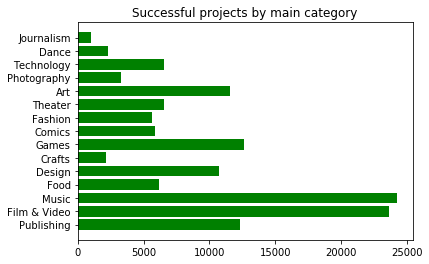

In [18]:
#bar chart of successful projects by category
values = list(successcounts.values())
plt.barh(range(len(successcounts)), values, tick_label=main_categories, color="green")
plt.title("Successful projects by main category")
plt.show()

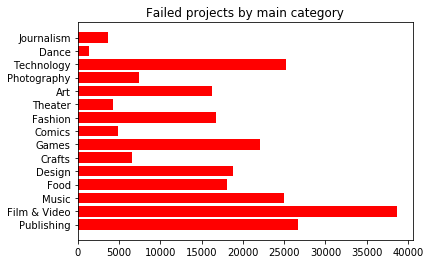

In [19]:
#bar chart of failed projects by category
values = list(failedcounts.values())
plt.barh(range(len(failedcounts)), values, tick_label=main_categories, color="red")
plt.title("Failed projects by main category")
plt.show()

In [20]:
failurerate = {}
i = 0
totalfails = len(data[(data["state"] == 0)])
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'pink', 'blue', 'cyan']

for i in range(0, len(main_categories)):
    failurerate[(main_categories[i])] = len(data[(data["main_category"] == main_categories[i]) & (data["goal_met"] ==  0)]) / totalfails
    
failurerate_sorted = sorted(failurerate.items(), key=operator.itemgetter(1))

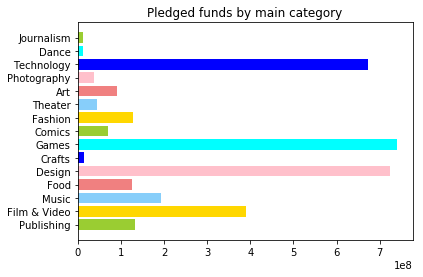

In [21]:
#bar chart of total donations by category
donationcounts = {}
i = 0

for i in range(0, len(main_categories)):
    c = data[data["main_category"] == (main_categories[i])]   
    donationsum = c["usd_pledged_real"].sum()
    donationsum = donationsum
    donationcounts[(main_categories[i])] = donationsum


donationvalues = list(donationcounts.values())    
plt.barh(range(len(donationcounts)), donationvalues, tick_label=main_categories, color=colors)
plt.title("Pledged funds by main category")
plt.show()

In [22]:
donationcounts_sorted = sorted(donationcounts.items(), key=operator.itemgetter(1))

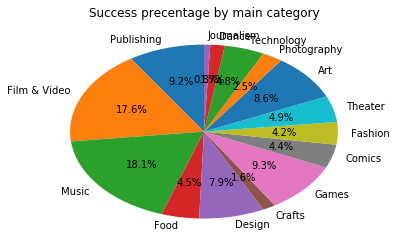

In [23]:
#success precentage by category
successrate = {}
i = 0
total = len(data[(data["state"] == 1)])

for i in range(0, len(main_categories)):
    successrate[(main_categories[i])] = len(data[(data["main_category"] == main_categories[i]) & (data["state"] ==  1)]) / total

plt.pie(successrate.values(), labels=main_categories, startangle=90, autopct='%.1f%%')
plt.title("Success precentage by main category")
plt.show()

In [24]:
successrate_sorted = sorted(successrate.items(), key=operator.itemgetter(1))
mostsuccessfulmaincategory = successrate_sorted[len(successrate_sorted)-1]

In [25]:
#category, usd_goal_real, country
categories = data["category"].unique()

#what sub category is the most succesful
successratebycategory ={}
i = 0

for i in range(0, len(categories)):
    successratebycategory[(categories[i])] = (len(data[(data["category"] == categories[i]) & (data["state"] ==  1)]) / total)
    
#the most succesful category is:
successratebycategory_sorted = sorted(successratebycategory.items(), key=operator.itemgetter(1))
mostsuccessfulcategory = successratebycategory_sorted[len(successratebycategory_sorted)-1]

#what country is the most succesful
successratebycountry ={}
countries = data["country"].unique()
i = 0

for i in range(0, len(countries)):
    successratebycountry[(countries[i])] = (len(data[(data["country"] == countries[i]) & (data["state"] ==  1)]) / total)

successratebycountry_sorted = sorted(successratebycountry.items(), key=operator.itemgetter(1))
mostsuccessfulcountry = successratebycountry_sorted[len(successratebycountry_sorted)-1]

In [26]:
#the most succesful category and country is:
print("Most succesful..")
print("Country:", mostsuccessfulcountry)
print("Category:", mostsuccessfulcategory)

Most succesful..
Country: ('US', 0.8159320971065126)
Category: ('Product Design', 0.059437427214906385)


In [27]:
#find out average time between launched and deadline dates of projects
timeframessuccessful = {}
timeframesfailed = {}

dls = successful["deadline"]
lncs = successful["launched"]

dlf = failed["deadline"]
lncf = failed["launched"]

betweensuccessful = dls - lncs
timeframessuccessful = betweensuccessful.dt.days

betweenfailed = dlf - lncf
timeframesfailed = betweenfailed.dt.days

meantimeframessuccessful = pd.DataFrame.mean(timeframessuccessful)
meantimeframesfailed = pd.DataFrame.mean(timeframesfailed)

print("successful timeframe mean: ", meantimeframessuccessful)
print("failed timeframe mean: ", meantimeframesfailed)

successful timeframe mean:  31.17025732427314
failed timeframe mean:  34.68354403538607


In [28]:
#add a timeframe column to the dataset
data["timeframe"] = (data["deadline"] - data["launched"]).dt.days

In [29]:
#from which country there are most projects

projectcountbycountry = {}
i = 0
totalprojects = len(data)

for i in range(0, len(countries)):
    projectcountbycountry[(countries[i])] = len(data[data["country"] == countries[i]])/totalprojects

projectcountbycountry_sorted = sorted(projectcountbycountry.items(), key=operator.itemgetter(1))

In [30]:
#because category is clearly a major factor in the success of the projects funding
#the category should be inculded in the predictions

data_dummies_maincategory = pd.get_dummies(data["main_category"])
data_dummies_country = pd.get_dummies(data["country"])
dummies_country_maincategory = data_dummies_maincategory.join(data_dummies_country)

In [31]:
#add another column for the ratio between mean goal and goal
usd_goal_real_mean = pd.DataFrame.mean(data["usd_goal_real"])
data["goal_to_mean_ratio"] = data["usd_goal_real"] / usd_goal_real_mean

In [32]:
data_y_dummies = pd.get_dummies(data["goal_met"])
data_trimmed = data.join(dummies_country_maincategory)
data_trimmed = data_trimmed.join(data_y_dummies)
data_trimmed = data_trimmed.drop("state", 1)

In [33]:
colnames = data_trimmed.columns.values.tolist()
predictors = colnames[12:(len(colnames)-3)]
target = colnames[11]

print("predictors: ", predictors)
print("target: ", target)

predictors:  ['timeframe', 'goal_to_mean_ratio', 'Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing', 'Technology', 'Theater', 'AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'N,0"', 'NL', 'NO', 'NZ', 'SE', 'SG']
target:  goal_met


In [34]:
#split data into train and test
data_trimmed['is_train'] = np.random.uniform(0, 1, len(data_trimmed)) <= .70
train, test = data_trimmed[data_trimmed['is_train']==True], data_trimmed[data_trimmed['is_train']==False]

In [35]:
#create decision tree
dt = DecisionTreeClassifier(criterion="entropy", min_samples_split=20, random_state=99)
dt.fit(train[predictors], train[target])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

In [36]:
preds=dt.predict(test[predictors])
pd.crosstab(test["goal_met"],preds,rownames=["Actual"], colnames=["Predictions"])

Predictions,0,1
Actual,,
0,56473,14081
1,24587,15884


In [37]:
#create a .dot file of the tree
from sklearn.tree import export_graphviz
with open('dtree_output/dtree.dot', 'w') as dotfile:
    export_graphviz(dt, out_file = dotfile, feature_names = predictors)
dotfile.close()

from os import system
system("dot -Tpng dtree_output/dtree.dot -o dtree_output/dtree_visualization.png")

1